In [183]:
import numpy as np
import pdb

from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import axes3d
from numpy import random as rnd
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=14)

In [184]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [196]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
# sigma1 = 1
# sigma0: parameter of interest

sigma1 = 1
sigma0 = 4

# number of data points
# TODO: run code with n=100000 
n = 1000

## Generate observed data

Previously, in the sanity check code, we considered the **normalised** mixture of gaussian model family:

$$ \phi(u, z; \theta) = (1-z) \frac{1}{\sqrt{2 \pi} \theta} e^{-\frac{u^2}{2 \theta^2}} + z \frac{1}{\sqrt{2 \pi} \sigma_1} e^{-\frac{u^2}{2 \sigma_1^2}} $$

Below, we consider the **unnormalised** mixture of gaussian model family, with an additional scaling parameter $c$:

\begin{align}
\phi(u, z; \theta, c) & = e^{-c} \left( (1-z) e^{-\frac{u^2}{2 \theta^2}} + z e^{-\frac{u^2}{2 \sigma_1^2}} \right) \\
                   & = e^{-c} \sqrt{2 \pi} \left( (1-z)  \theta \mathcal{N}(u, \theta) + 
                                            z \sigma_1 \mathcal{N}(u;\sigma_1) \right)
\end{align}

where $z \sim \mathcal{Ber}(\frac{1}{2})$.

(note that the first family is not nested in the latter - you would need two scaling parameters, one for each unnormalised gaussian).

Integrating this family yields the partition function:

$$ Z(\theta, c) = \frac{e^{-c}\sqrt{2\pi}}{2} ( \theta + \sigma_1 ) $$

Therefore, the corresponding normalised family has the form:

\begin{align} 
    p_m(u; \theta) & = \frac{\mathbb{E}_z(\phi(u, z, \theta, c))}{Z(\theta, c)} \\
                 & = \frac{e^{-c}\frac{\sqrt{2 \pi}}{2} \left( \theta \mathcal{N}(u, \theta) + 
                                            \sigma_1 \mathcal{N}(u;\sigma_1) \right)}{Z(\theta, c)} \\
                 & = \frac{\theta}{\theta + \sigma_1} \mathcal{N}(u; 0, \theta) +
                     \frac{\sigma_1}{\theta + \sigma_1} \mathcal{N}(u; 0, \sigma_1)
\end{align}

this last formula gives us a way to easily generate synthetic data. fixing $\theta = \sigma_0$, we get:

\begin{align} 
        p_x(u)  =  \mathbb{E}_{w}\left( (1-w) \mathcal{N}(u; 0, \sigma_0) + w \mathcal{N}(u; 0, \sigma_1) \right))
\end{align}

 where $ w \sim \mathcal{Ber}(\frac{\sigma_1}{\sigma_1 + \sigma_0}) $.
 
So, if $\sigma_0 = 4$ and $\sigma_1^2 = 1$, then we can toss a biased coin $ w \sim \mathcal{Ber}(\frac{1}{5}) $, and then draw a data point $x$ from the corresponding gaussian.

We can also calculate in advance the optimal value of $c$, call it $c_0$, that we want to estimate. $c_0$ should satisfy:

$$ 
Z(\sigma_0, c_0) = 1 \\
\Rightarrow \ \ \ \ \ c_0 = -\log(2) + \frac{1}{2}\log(2\pi) + \log(\sigma_0 + \sigma_1) 
$$

For the values $\sigma_0 = 4$ and $\sigma_1^2 = 1$, this implies $c_0 \approx 1.8352292650788278$.

In [197]:
c0 = 1.8352292650788278

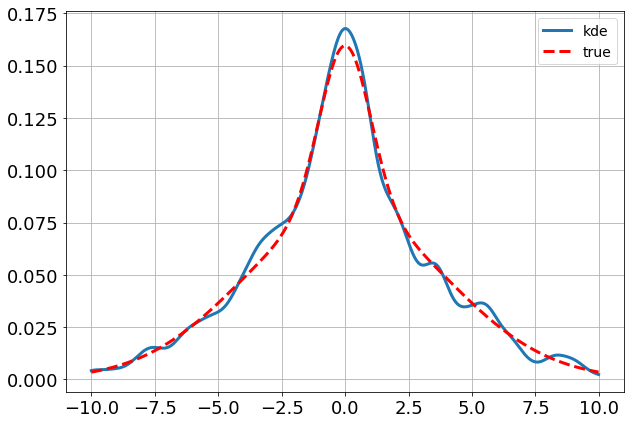

In [200]:
a = sigma1 / (sigma0 + sigma1)
w = rnd.uniform(0,1, n) < a

# generate synthetic data
x = ((w==0)*(rnd.randn(n)*sigma0) + (w==1)*(rnd.randn(n)*sigma1)).reshape(-1,1)

# check synthetic data was drawn from correct distribution
fig = plt.figure(figsize=(10,7))
u = np.arange(-10,10,0.01).reshape(-1,1)

# plot the kernel denstiy estimate of synthetic data
x_density = kd(bandwidth=0.4).fit(x)
x_density_samples = np.exp(x_density.score_samples(u))
plt.plot(u, x_density_samples, label='kde')

# plot the true density of the data
px = (1-a)*norm.pdf(u, 0, sigma0) + a*norm.pdf(u, 0, sigma1)
plt.plot(u, px, label='true', c='r', linestyle = '--')

# plot the true density using a different calculation
#px2 = (np.exp(-c0) / 2)*(np.exp(-u**2 / 32) + np.exp(-u**2/2))
#plt.plot(u, px2, label='also true', c='g', linestyle = '--')

plt.legend()
plt.grid()

## NCE objective function

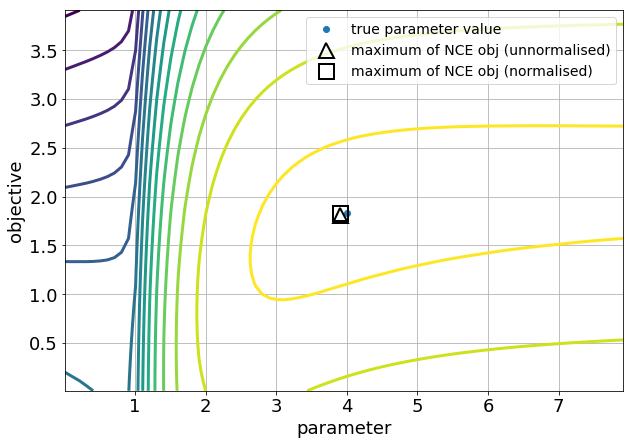

In [201]:
# nu is the ratio of noise to data samples
nu = 1

theta = np.arange(0.01, 8, 0.1)
c = np.arange(0.01, 4, 0.1) 

n_theta = len(theta)
n_c = len(c)

pn = lambda u: norm.pdf(u,0, sigma0) # noise that matches the larger std
y = sigma0 * rnd.randn(n*nu) # generate noise data

# unnormalised model with z integrated out
phi_m = lambda u, theta, c: (np.exp(-c)/2) * (np.exp(-u**2/ (2*(theta**2))) + np.exp(-u**2/ (2)))

h = lambda u, theta, c: np.log(phi_m(u, theta, c)/pn(u)) # quick hack: generally better to work in log domain!

# normalised model, for comparison. Recall that a = sigma1 / (sigma0 + sigma1)
pm = lambda u, theta: (1-a)*(norm.pdf(u,0,theta) + a*norm.pdf(u, 0, sigma1))

h_norm = lambda u, theta: np.log(pm(u, theta)/pn(u)) # for comparison

J = np.zeros((n_theta, n_c))
J_norm = np.zeros(n_theta) # objective evaluated on normalised model, for comparison

for k in range(n_theta):
    theta_k = theta[k]
    J_norm[k] = -np.mean( np.log(1 + nu*np.exp(-h_norm(x,theta_k))) ) - \
                    nu* np.mean( np.log(1 + 1/nu*np.exp(h_norm(y,theta_k))) )
    for m in range(n_c):
        c_m = c[m]
        J[k, m] = -np.mean( np.log(1 + nu*np.exp(-h(x,theta_k, c_m))) ) - \
                    nu* np.mean( np.log(1 + 1/nu*np.exp(h(y,theta_k, c_m))) )
        


fig = plt.figure(figsize=(10,7))

X, Y = np.meshgrid(theta, c)
plt.contour(X, Y, J.T, 15)

plt.plot(sigma0, c0,'o', label='true parameter value')

index = np.argmax(J) # this is the index for the flattened array
row = int(index/n_c)
column = index % n_c

plt.plot(theta[row], c[column], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE obj (unnormalised)')

index2 = np.argmax(J_norm) # this is the index for the flattened array

plt.plot(theta[index2], c0, marker='s', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE obj (normalised)')

plt.xlabel('parameter')
plt.ylabel('objective')

plt.grid()
lgd = plt.legend(loc='best', numpoints=1)

## First lower bound

In order to obtain a lower bound on the first term in the NCE objective function, we need to specify a variational posterior distribution that can 'fill in' the missing values $z$.

As in the sanity check code, we use $p(z \ | \ x)$, which can be computed as:

\begin{align}
q_u(z=0 \ | \ u) & = p(z=0 \ | \ u) \\
             & = \frac{1}{1 + \exp(\frac{-u^2}{2} (\frac{1}{\sigma_1^2} + \frac{1}{\sigma_0^2}) )}
\end{align}

In [203]:
q0 = lambda u: 1 / (1 + np.exp(-((u**2)/2)*(1/sigma1**2 - 1/sigma0**2)))
q1 = lambda u: 1 - q0(u) 

phi0 = lambda u, theta, c:  0.5*np.exp(-c)*np.exp(-u**2/(2*(theta**2)))
phi1 = lambda u, theta, c:  0.5*np.exp(-c)*np.exp(-u**2/(2*(sigma1**2)))

r0 = lambda u, theta, c : phi0(u,theta, c)/( q0(u)*pn(u) + 10**(-15))
r1 = lambda u, theta, c : phi1(u,theta, c)/( q1(u)*pn(u) + 10**(-15))
r = lambda u, z, theta, c : (z==0)*r0(u, theta, c) + (z==1)*r1(u, theta, c)

# TODO: How are the results affected if we use rnd.uniform(0, 1, (n,n))?
zx = rnd.uniform(0, 1, n) < q1(x)

J1 = np.zeros((n_theta, n_c))
Jlower = np.zeros((n_theta, n_c))
eps = 10**(-15) # to avoid division by zero
for k in range(n_theta):
    theta_k = theta[k]
    for m in range(n_c):
        c_m = c[m]
        
        # compute expectation for 2nd term of J1
        E = q0(y)*r0(y,theta_k, c_m) + q1(y)*r1(y,theta_k, c_m)

        # J1 objective
        J1[k, m] = -np.mean(np.log(1 + nu*1/(r(x, zx, theta_k, c_m) + eps))) \
                   - nu*np.mean( np.log(1 + 1/(nu*E + eps)))

        # Jlower is the objective after inserting the bound for the first term in the NCE obj,  
        # but before applying importance sampling to the second term
        Jlower[k, m] = -np.mean( np.log(1+nu*1/(r(x,zx,theta_k, c_m) + eps))) \
                     - nu* np.mean( np.log(1+1/(nu*np.exp(h(y,theta_k, c_m)) + eps)) )

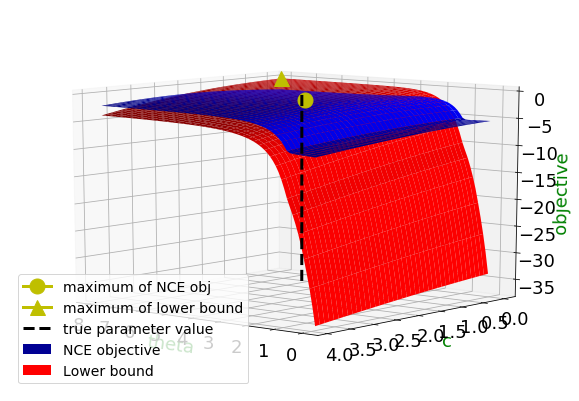

In [218]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(theta, c)

s1 = ax.plot_surface(X, Y, J.T, color='b',label='NCE objective')
s2 = ax.plot_surface(X, Y, J1.T, color='r', label='Lower bound')
#s3 = ax.plot_surface(X, Y, Jlower.T, color='g', label='Lb w/o importance sampling')

s1._facecolors2d=s1._facecolors3d
s2._facecolors2d=s2._facecolors3d
#s3._facecolors2d=s3._facecolors3d
s1._edgecolors2d=s1._edgecolors3d
s2._edgecolors2d=s2._edgecolors3d
#s3._edgecolors2d=s3._edgecolors3d

# maximiser of NCE obj
point1, = ax.plot([theta[row]], [c[column]], [J[row, column]], marker='o', markersize=15, 
        c='y', label='maximum of NCE obj')

# calculate the optimal parameter values for J1
index3 = np.argmax(J1) # this is the index for the flattened array
row3 = int(index3/n_c)
column3 = index3 % n_c

point2, = ax.plot([theta[row3]], [c[column3]], [J1[row3, column3]], marker='^', markersize=15, 
        c='y', label='maximum of lower bound')

# true param value
line, = ax.plot([sigma0,sigma0], [c0, c0], [-35,0], 'k--', label='true parameter value')

ax.set_xlabel('theta', color='g')
ax.set_ylabel('c', color='g')
ax.set_zlabel('objective', color='g')
plt.legend( loc='lower left', numpoints=1)
plt.grid()

ax.view_init(10, 130)
plt.draw()

In [ ]:
theta[row], c[column]

In [ ]:
theta[row3],c[column3]

In [217]:
np.sum(J1 < J) / (J.size), np.sum(Jlower < J) / (J.size)

(0.65468749999999998, 0.65468749999999998)